# Phase 1: Preprocessing

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import wavfile
import math
from scipy.signal import butter, sosfilt, medfilt

First, we preprocess the data by removing noises using butterworth bandpass filter which only captures 70-1500 Hz frequency range; since the noises have some high frequency range in addition to some low frequency noises. Also, to remove the white noise we use the Median Filter, with a kernel size of 3(which is default).

In [2]:
train_data = []
train_data_proper = []
train_labels = np.array([])
train_labels_proper = np.array([])
Fs = 8000

for j in range(10):
    for i in range(200):
        path = './Dataset/train/' + str(j) + '/' + str(i) + '.wav'
        _, data = wavfile.read(path)
        #Filter the data using bandpass filter
        sos = butter(N=7, Wn=[70, 1500], btype='bandpass', fs=Fs, output='sos')
        filtered_data = sosfilt(sos, data)
        #Remove white noise by using median filter
        denoised_data = medfilt(filtered_data)
        
        train_labels = np.append(train_labels, j)
        train_data.append(denoised_data/max(denoised_data))

In [3]:
test_data = []
test_labels = np.array([])
Fs = 8000
for j in range(10):
    for i in range(50):
        test_labels = np.append(test_labels, j)
        path = './Dataset/test/' + str(j) + '/' + str(i) + '.wav'
        _, data = wavfile.read(path)
        #Filter the data using bandpass filter
        sos = butter(N=7, Wn=[70, 1500], btype='bandpass', fs=Fs, output='sos')
        filtered_data = sosfilt(sos, data)
        #Remove white noise by using median filter
        denoised_data = medfilt(filtered_data)
        
        test_data.append(denoised_data/max(denoised_data))

To illustrate the effect of filtering, we plot a sample data in the below diagrams:

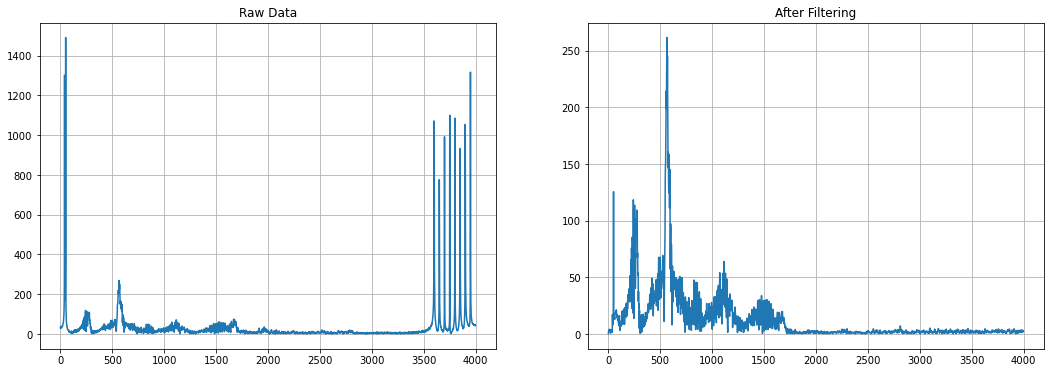

In [778]:
from scipy.fft import fft, fftfreq
fig, ax = plt.subplots(1, 2, figsize = (18,6))
# Number of sample points
N = len(data)
# sample spacing
T = 1.0 / Fs
x = np.linspace(0.0, N*T, N, endpoint=False)
y = data
yf = fft(y)
xf = fftfreq(N, T)[:N//2]
ax[0].plot(xf, 2.0/N * np.abs(yf[0:N//2]))
ax[0].grid()
ax[0].set_title('Raw Data')

y = denoised_data
yf=fft(y)
ax[1].plot(xf, 2.0/N * np.abs(yf[0:N//2]))
ax[1].grid()
ax[1].set_title('After Filtering');

Since the model needs to have all samples in the same length, we use a threshold of 4000 samples for our data; meaning that shorter samples are zero-padded to have the specified length and longer samples are trunctuated. This value of threshold is chosen since about 75% of train data are shorter than this and this is nearly the mean value of sample lengths.

In [4]:
threshold = 4000

X_train = []
for x in train_data:
    if (len(x) >= threshold):
        diff = len(x) - threshold
        trunc_audio = x[math.floor(diff/2):len(x)-math.ceil(diff/2)]
        X_train.append(trunc_audio)
        
    else:
        diff = threshold - len(x)
        padded_audio = np.zeros(threshold)
        padded_audio[math.floor(diff/2):threshold-math.ceil(diff/2)] = np.array(x)
        X_train.append(padded_audio)

X_train_proper = []
for x in train_data_proper:
    if (len(x) >= threshold):
        diff = len(x) - threshold
        trunc_audio = x[math.floor(diff/2):len(x)-math.ceil(diff/2)]
        X_train_proper.append(trunc_audio)
        
    else:
        diff = threshold - len(x)
        padded_audio = np.zeros(threshold)
        padded_audio[math.floor(diff/2):threshold-math.ceil(diff/2)] = np.array(x)
        X_train_proper.append(padded_audio)

        
X_test = []
for x in test_data:
    if (len(x) >= threshold):
        diff = len(x) - threshold
        trunc_audio = x[math.floor(diff/2):len(x)-math.ceil(diff/2)]
        X_test.append(trunc_audio)
        
    else:
        diff = threshold - len(x)
        padded_audio = np.zeros(threshold)
        padded_audio[math.floor(diff/2):threshold-math.ceil(diff/2)] = np.array(x)
        X_test.append(padded_audio)

In [5]:
X_train = np.array(X_train)
Y_train = train_labels

X_test = np.array(X_test)
Y_test = test_labels

In [6]:
from sklearn.decomposition import PCA

nf = 1000
pca = PCA(n_components=nf)
pca.fit(X_train)
X_train_new = pca.transform(X_train)
X_test_new = pca.transform(X_test)

# Phase 2: Supervised Learning 

### Training the model without explicit audio feature extraction:

##### SVM

In [6]:
import sklearn
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

We try to find the best hyperparameters for our SVM model using grid search with K-fold cross validation as below:

In [21]:
hyperparameters = {'C': [1, 10, 20], 'gamma': ['scale'], 'degree':[3,5], 'kernel':['rbf', 'linear', 'poly']} 
grid_svm = GridSearchCV(SVC(), hyperparameters, scoring='accuracy', refit=True, verbose=3, cv=4) 

grid_svm.fit(X_train_new, Y_train)

Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV 1/4] END C=1, degree=3, gamma=scale, kernel=rbf;, score=0.248 total time=   1.2s
[CV 2/4] END C=1, degree=3, gamma=scale, kernel=rbf;, score=0.222 total time=   1.2s
[CV 3/4] END C=1, degree=3, gamma=scale, kernel=rbf;, score=0.194 total time=   1.2s
[CV 4/4] END C=1, degree=3, gamma=scale, kernel=rbf;, score=0.268 total time=   1.2s
[CV 1/4] END C=1, degree=3, gamma=scale, kernel=linear;, score=0.146 total time=   1.2s
[CV 2/4] END C=1, degree=3, gamma=scale, kernel=linear;, score=0.144 total time=   1.3s
[CV 3/4] END C=1, degree=3, gamma=scale, kernel=linear;, score=0.172 total time=   1.3s
[CV 4/4] END C=1, degree=3, gamma=scale, kernel=linear;, score=0.162 total time=   1.4s
[CV 1/4] END C=1, degree=3, gamma=scale, kernel=poly;, score=0.100 total time=   1.1s
[CV 2/4] END C=1, degree=3, gamma=scale, kernel=poly;, score=0.104 total time=   1.1s
[CV 3/4] END C=1, degree=3, gamma=scale, kernel=poly;, score=0.102 total ti

GridSearchCV(cv=4, estimator=SVC(),
             param_grid={'C': [1, 10, 20], 'degree': [3, 5], 'gamma': ['scale'],
                         'kernel': ['rbf', 'linear', 'poly']},
             scoring='accuracy', verbose=3)

The best parameters are:

In [22]:
grid_svm.best_params_

{'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}

In [8]:
#Scalerization did not improve the results; Also, PCA didn't have much effect on accuracy
"""
scaler_X = StandardScaler().fit(X_train_proper)
X_train_scaled = scaler_X.transform(X_train_proper)
X_test_scaled = scaler_X.transform(X_test)
"""

svm_model = SVC(kernel='rbf', C=10, gamma='scale', random_state=0).fit(X_train, Y_train)
print("Accuracy on train set:",svm_model.score(X_train, Y_train))
print("Accuracy on test set:",svm_model.score(X_test, Y_test))

Accuracy on train set: 0.996
Accuracy on test set: 0.292


###### Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression


#Scalerization did not improve the results; Also, PCA didn't have much effect on accuracy
"""
scaler_X = StandardScaler().fit(X_train_proper)
X_train_scaled = scaler_X.transform(X_train_proper)
X_test_scaled = scaler_X.transform(X_test)
"""

LR_model = LogisticRegression(C=1, solver='lbfgs', multi_class='ovr', max_iter=1000, random_state=0)
LR_model.fit(X_train, np.ravel(Y_train))

print('Accuracy of model on train set:', LR_model.score(X_train, Y_train))
print('Accuracy of model on test set:', LR_model.score(X_test, Y_test))

Accuracy of model on train set: 0.931
Accuracy of model on test set: 0.168


###### LDA & QDA

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

#PCA and scalerization slightly improved the results
scaler_X = StandardScaler().fit(X_train_new)
X_train_scaled = scaler_X.transform(X_train_new)
X_test_scaled = scaler_X.transform(X_test_new)


lda_model = LDA().fit(X_train_scaled, np.ravel(Y_train))
print('Accuracy of model on train set:', lda_model.score(X_train_scaled, Y_train))
print('Accuracy of model on test set:', lda_model.score(X_test_scaled, Y_test))

Accuracy of model on train set: 0.8325
Accuracy of model on test set: 0.152


In [12]:
#PCA and scalerization slightly improved the results
scaler_X = StandardScaler().fit(X_train_new)
X_train_scaled = scaler_X.transform(X_train_new)
X_test_scaled = scaler_X.transform(X_test_new)


qda_model = QDA().fit(X_train_scaled, np.ravel(Y_train))
print('Accuracy of model on train set:', qda_model.score(X_train_scaled, Y_train))
print('Accuracy of model on test set:', qda_model.score(X_test_scaled, Y_test))

C:\Users\alire\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy of model on train set: 1.0
Accuracy of model on test set: 0.114


###### Naive Bayes

In [13]:
from sklearn.naive_bayes import GaussianNB

gNB_model = GaussianNB().fit(X_train, Y_train)
print('Accuracy of model on train set:', gNB_model.score(X_train, Y_train))
print('Accuracy of model on test set:', gNB_model.score(X_test, Y_test))

Accuracy of model on train set: 0.3215
Accuracy of model on test set: 0.294


In [17]:
from sklearn.naive_bayes import MultinomialNB
X_train_t = np.abs(X_train)
X_test_t = np.abs(X_test)

mNB_model = MultinomialNB().fit(X_train_t, Y_train)
print('Accuracy of model on train set:', mNB_model.score(X_train_t, Y_train))
print('Accuracy of model on test set:', mNB_model.score(X_test_t, Y_test))

Accuracy of model on train set: 0.3285
Accuracy of model on test set: 0.314


###### KNN

In [731]:
from sklearn.neighbors import KNeighborsClassifier as KNN

knn_model = KNN(n_neighbors=1).fit(X_train, Y_train)
print('Accuracy of model on train set:', knn_model.score(X_train, Y_train))
print('Accuracy of model on test set:', knn_model.score(X_test, Y_test))

Accuracy of model on train set: 1.0
Accuracy of model on test set: 0.17


###### Random Forest

In [180]:
from sklearn.ensemble import RandomForestClassifier as Random_Forest

hyperparameters = {'n_estimators':[100, 200],
                   'criterion':['gini', 'entropy'],
                   'max_depth':[50, 100],
                   'min_samples_split':[10],
                   'min_samples_leaf':[5]} 

grid_rf = GridSearchCV(Random_Forest(), hyperparameters, scoring='accuracy', refit=True, verbose=3, cv=4) 
grid_rf.fit(X_train, Y_train)

Fitting 4 folds for each of 8 candidates, totalling 32 fits
[CV 1/4] END criterion=gini, max_depth=50, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.372 total time=   8.0s
[CV 2/4] END criterion=gini, max_depth=50, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.334 total time=   7.7s
[CV 3/4] END criterion=gini, max_depth=50, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.334 total time=   7.9s
[CV 4/4] END criterion=gini, max_depth=50, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.368 total time=   7.9s
[CV 1/4] END criterion=gini, max_depth=50, min_samples_leaf=5, min_samples_split=10, n_estimators=200;, score=0.362 total time=  15.7s
[CV 2/4] END criterion=gini, max_depth=50, min_samples_leaf=5, min_samples_split=10, n_estimators=200;, score=0.356 total time=  15.1s
[CV 3/4] END criterion=gini, max_depth=50, min_samples_leaf=5, min_samples_split=10, n_estimators=200;, score=0.330 total time=  1

GridSearchCV(cv=4, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [50, 100], 'min_samples_leaf': [5],
                         'min_samples_split': [10],
                         'n_estimators': [100, 200]},
             scoring='accuracy', verbose=3)

In [181]:
grid_rf.best_params_

{'criterion': 'gini',
 'max_depth': 100,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'n_estimators': 200}

In [29]:
rf_model = Random_Forest(n_estimators=500,
                         criterion='gini',
                         max_depth=100,
                         min_samples_split=10,
                         min_samples_leaf=5,
                         max_samples=1000,
                         random_state=0)

rf_model.fit(X_train, Y_train)

print('Accuracy of model on train set:', rf_model.score(X_train, Y_train))
print('Accuracy of model on test set:', rf_model.score(X_test, Y_test))

Accuracy of model on train set: 0.9785
Accuracy of model on test set: 0.406


###### Adaboost

In [37]:
from sklearn.ensemble import AdaBoostClassifier as Adaboost

adb_model = Adaboost(n_estimators=100, random_state=0).fit(X_train, Y_train)
print('Accuracy of model on train set:', adb_model.score(X_train, Y_train))
print('Accuracy of model on test set:', adb_model.score(X_test, Y_test))

Accuracy of model on train set: 0.2875
Accuracy of model on test set: 0.246


###### xGBoost

The best parameters for extreme gradient boosting model was found by grid search as well, but to avoid much details, we just use them in our model.

In [62]:
from xgboost import XGBClassifier as XGB
xgb_model = XGB(n_estimators=100, grow_policy='depthwise',
                use_label_encoder=None, random_state=0)
xgb_model.fit(X_train, Y_train)

print('Accuracy of model on train set:', xgb_model.score(X_train, Y_train))
print('Accuracy of model on test set:', xgb_model.score(X_test, Y_test))

[23:27:48] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of model on train set: 1.0
Accuracy of model on test set: 0.434


In [64]:
yhat_test = xgb_model.predict(X_test)
cm = confusion_matrix(Y_test, yhat_test)
conf_xgb = pd.DataFrame(cm)
conf_xgb

,0,1,2,3,4,5,6,7,8,9
0,29,2,2,2,2,0,2,2,2,7
1,1,11,0,3,2,8,3,4,8,10
2,5,3,24,9,1,0,5,1,1,1
3,4,3,15,15,1,0,4,3,2,3
4,3,3,3,9,14,4,0,6,5,3
5,3,3,0,1,0,25,6,2,5,5
6,0,0,7,2,0,1,28,3,9,0
7,7,6,0,6,6,5,0,14,1,5
8,1,3,3,0,1,0,6,1,32,3
9,3,6,2,1,2,5,1,4,1,25


We save this model using Pickle module since this is our best single model: 

In [708]:
import pickle

with open('AlirezaGargoori_98102176/Phase_1/Model_Phase1a.pkl', 'wb') as files:
    pickle.dump(xgb_model, files)

<br><center> -----------------------------------------------------------------------------------------

To summarize the above steps, we define two functions to predict the outputs, one for the purpose of preprocessing the data and the other to predict the outputs and print accuracies on both the train and test sets.

In [732]:
def load_preprocess_data(path):
    Fs = 8000
    
    train_data = []
    train_labels = np.array([])
    for j in range(10):
        for i in range(200):
            path_train = path + 'train/' + str(j) + '/' + str(i) + '.wav'
            _, data = wavfile.read(path_train)
            #Filter the data using bandpass filter
            sos = butter(N=7, Wn=[70, 1500], btype='bandpass', fs=Fs, output='sos')
            filtered_data = sosfilt(sos, data)
            #Remove white noise by using median filter
            denoised_data = medfilt(filtered_data)

            train_labels = np.append(train_labels, j)
            train_data.append(denoised_data/max(denoised_data))
                
    
    test_data = []
    test_labels = np.array([])
    for j in range(10):
        for i in range(50):
            test_labels = np.append(test_labels, j)
            path_test = path + 'test/' + str(j) + '/' + str(i) + '.wav'
            _, data = wavfile.read(path_test)
            #Filter the data using bandpass filter
            sos = butter(N=7, Wn=[70, 1500], btype='bandpass', fs=Fs, output='sos')
            filtered_data = sosfilt(sos, data)
            #Remove white noise by using median filter
            denoised_data = medfilt(filtered_data)

            test_data.append(denoised_data/max(denoised_data))

            
    #Zero padding and tructuate to make all samples the same length
    threshold = 4000
    X_train = []
    for x in train_data:
        if (len(x) >= threshold):
            diff = len(x) - threshold
            trunc_audio = x[math.floor(diff/2):len(x)-math.ceil(diff/2)]
            X_train.append(trunc_audio)

        else:
            diff = threshold - len(x)
            padded_audio = np.zeros(threshold)
            padded_audio[math.floor(diff/2):threshold-math.ceil(diff/2)] = np.array(x)
            X_train.append(padded_audio)


    X_test = []
    for x in test_data:
        if (len(x) >= threshold):
            diff = len(x) - threshold
            trunc_audio = x[math.floor(diff/2):len(x)-math.ceil(diff/2)]
            X_test.append(trunc_audio)

        else:
            diff = threshold - len(x)
            padded_audio = np.zeros(threshold)
            padded_audio[math.floor(diff/2):threshold-math.ceil(diff/2)] = np.array(x)
            X_test.append(padded_audio)
            
            
                  
    X_train = np.array(X_train)
    Y_train = train_labels

    X_test = np.array(X_test)
    Y_test = test_labels
    
    
    return X_train, Y_train, X_test, Y_test

In [733]:
def Predict_Phase1(path_data, path_module):
    #Preprocess the data
    X_train, Y_train, X_test, Y_test = load_preprocess_data(path_data)
    
    with open(path_module + 'Model_Phase1a.pkl', 'rb') as f:
        phase1_model = pickle.load(f)
    
    print('Accuracy of the best model on train set:', phase1_model.score(X_train, Y_train))
    print('Accuracy of the best model on test set:', phase1_model.score(X_test, Y_test))
    
    np.save(path_module+'phase1a_predicted.npy', phase1_model.predict(X_test))

In [734]:
Predict_Phase1('AlirezaGargoori_98102176/Dataset/', 'AlirezaGargoori_98102176/Phase_1/')

Accuracy of the best model on train set: 1.0
Accuracy of the best model on test set: 0.434


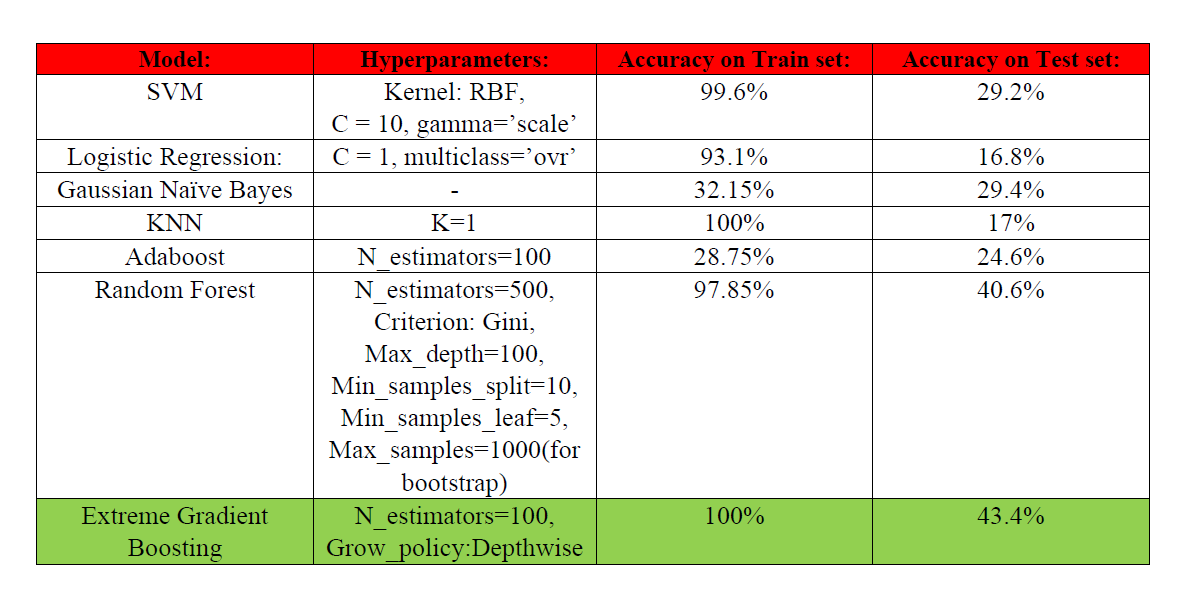

As we can see, the best model was found by extreme gradient boosting algorithm which its accuracy on test set is still far away from what we can consider a good classifier. Also, we can see that this model is heavily overfitted and we need some good features to have a better model which is implicated in the next part:

## Feature Extraction

The Gabor transform, is a special case of the short-time Fourier transform. It is used to determine the sinusoidal frequency and phase content of local sections of a signal as it changes over time. The function to be transformed is first multiplied by a Gaussian function, which can be regarded as a window function, and the resulting function is then transformed with a Fourier transform to derive the time-frequency analysis.

The gabor transform of a signal $x(t)$ is defined by:
<br><center> $G_x(\tau,\omega) = \int_{-\infty}^\infty x(t)e^{-\pi(t-\tau)^2}e^{-j \omega t}\,dt$
    
    
So, by using Gabor transform and with an appropirate window size, we can get the signal spectogram.

We use the signal **spectogram** to extract some features since the frequency of each audio can have a large amount of useful information. Also, we flatten each spectogram to have a feature vector for each sample. The size of window was chosen by trial-and-error to find the optimal value: (Just to note, PCA and Kernel PCA and other dimensionality reduction techniques such as manifold learning techniques did not imporve our results; hence the codes regrading these methods are removed from this notebook.)

In [743]:
from scipy import signal
from scipy.signal import windows

X_train_tf = [] 
X_test_tf = [] 
 
for x in X_train: 
    _,_, Sx = signal.spectrogram(x, 8000, window=windows.hann(120)) 
    X_train_tf.append(np.ravel(Sx)) 
 
for x in X_test: 
    _,_, Sx = signal.spectrogram(x, 8000, window=windows.hann(120)) 
    X_test_tf.append(np.ravel(Sx)) 
 
 
X_train_tf = np.array(X_train_tf)
X_test_tf = np.array(X_test_tf)

A sample spectogram of each Class is plotted in the below digaram:

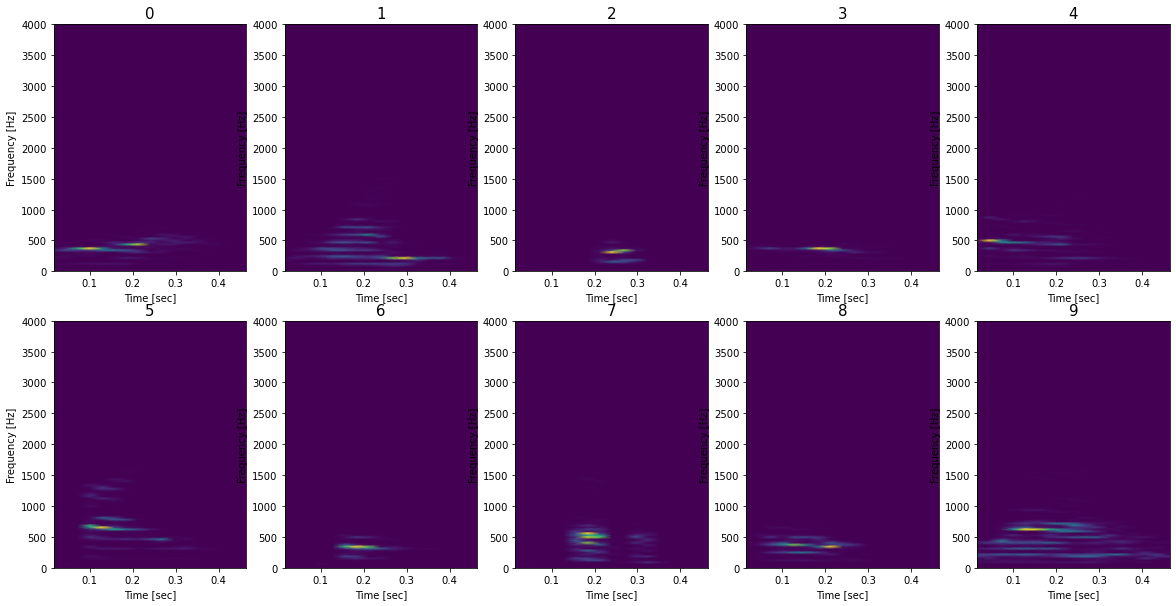

In [773]:
plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(2,5,i+1)
    f,t, Sxx = signal.spectrogram(X_train[200*i+100,:], 8000)
    plt.pcolormesh(t, f, Sxx, shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title(i, fontsize=15)


###### xGBoost

In [744]:
xgb_model_tf = XGB(n_estimators=400, grow_policy='depthwise',
                   use_label_encoder=None, learning_rate=0.1,
                   random_state=0)
xgb_model_tf.fit(X_train_tf_new, Y_train)

print('Accuracy of model on train set:', xgb_model_tf.score(X_train_tf_new, Y_train))
print('Accuracy of model on test set:', xgb_model_tf.score(X_test_tf_new, Y_test))

[19:02:40] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of model on train set: 1.0
Accuracy of model on test set: 0.884


###### Random Forest

In [751]:
rf_model_tf = Random_Forest(n_estimators=500,
                         criterion='gini',
                         max_depth=100,
                         min_samples_split=5,
                         min_samples_leaf=1,
                         #max_samples=2000,
                         random_state=0)

rf_model_tf.fit(X_train_tf, Y_train)

print('Accuracy of model on train set:', rf_model_tf.score(X_train_tf, Y_train))
print('Accuracy of model on test set:', rf_model_tf.score(X_test_tf, Y_test))

Accuracy of model on train set: 1.0
Accuracy of model on test set: 0.892


Confusion matrix of this model is:

In [782]:
yhat_test = rf_model_tf.predict(X_test_tf)
cm = confusion_matrix(Y_test, yhat_test)
conf_rf = pd.DataFrame(cm)
conf_rf

,0,1,2,3,4,5,6,7,8,9
0,48,0,0,0,0,0,0,0,2,0
1,0,41,0,0,1,5,1,0,0,2
2,1,0,45,1,0,0,1,0,2,0
3,0,1,6,40,0,0,2,0,1,0
4,0,4,0,0,46,0,0,0,0,0
5,0,0,0,0,1,44,0,0,0,5
6,0,0,1,0,0,0,45,1,3,0
7,1,0,1,0,0,0,0,47,1,0
8,0,0,0,2,1,0,1,0,46,0
9,1,0,0,0,0,4,0,1,0,44


##### SVM

In [803]:
svm_model_tf = SVC(C=21, kernel='rbf', gamma='scale', probability=True, random_state=0).fit(X_train_tf, Y_train)
print('Accuracy of model on train set:', svm_model_tf.score(X_train_tf, Y_train))
print('Accuracy of model on test set:', svm_model_tf.score(X_test_tf, Y_test))

Accuracy of model on train set: 0.9905
Accuracy of model on test set: 0.804


### An Ensemble Learning Method: Stacking Classifiers to boost performance
As we can see, all the models had a significantly better performance using the spectogram of each signal as the feature vector; However, still none of the above models could reach a 90% accuracy on test set. A possible booster algorithm is to use the wisdom of each classifier and stack them to reach a higher accuracy as described below:

The simplest form of stacking can be described as an ensemble learning technique where the predictions of multiple classifiers (referred as level-one classifiers) are used as new features to train a meta-classifier. The meta-classifier can be any classifier of your choice. (which here we used SVM with a RBF kernel and tuned hyperparamters.) The below figure can help to understand the model better:

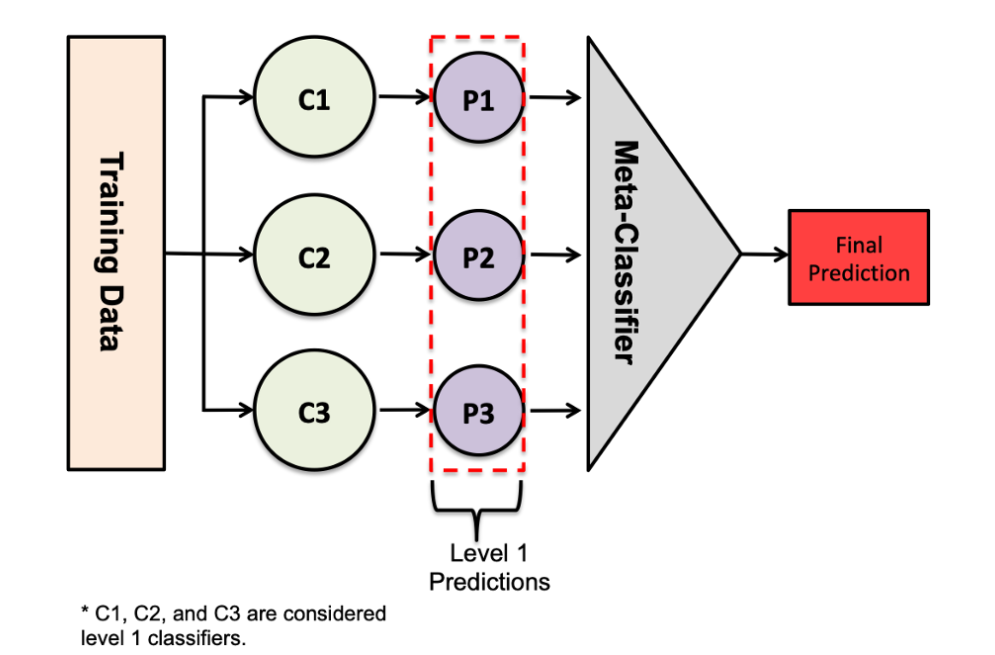

To prevent information from leaking into the training from the target (the thing you’re trying to predict), the following rule should be followed when stacking classifiers:
**The level one predictions should come from a subset of the training data that was not used to train the level one classifiers.**

A more robust way to do this, is to use k-fold cross validation to generate the level one predictions. Here, the training data is split into k-folds. Then the first k-1 folds are used to train the level one classifiers. The validation fold is then used to generate a subset of the level one predictions. The process is repeated for each unique group:

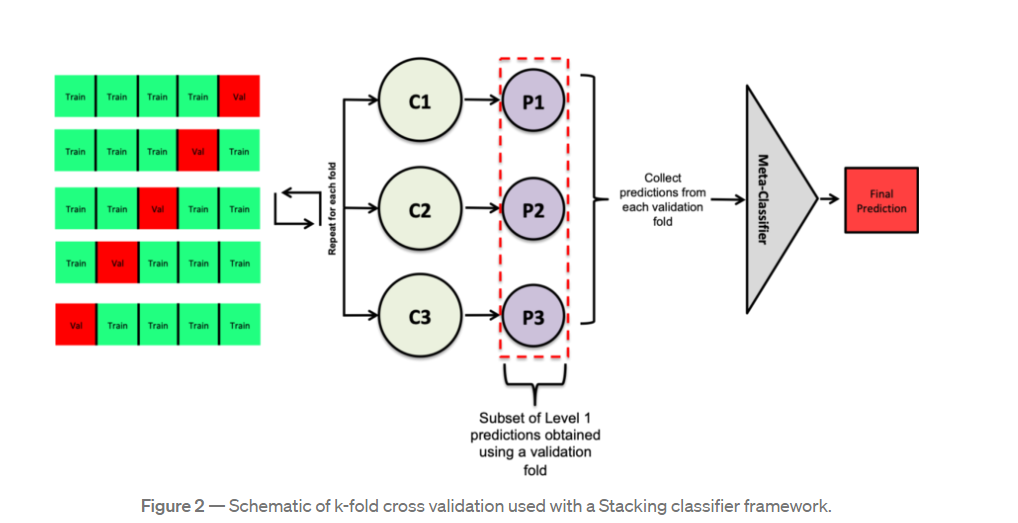

Here, we use our xGBoost model, SVM model and Random Forest model as the level-1 classifiers and stack them together for our meta-classifier which is an SVM model with RBF kernel. Since the Grid Search for this classifier takes too long to find the optimal values, we first tune the hyperparameters of each level-1 classifier and then find the optimal hyperparamters for our meta-classifier using Grid Search. Also, instead of using binary outputs of level-1 predictions, we used their output probability(which is a technique that worked better here, but not necessarily always better):

### *Meta-Classifier: Stacking Classifiers*

Before running the below cell, make sure to install MLXtend library.

In [847]:
from mlxtend.classifier import StackingCVClassifier             

stack_clf = StackingCVClassifier(classifiers = [svm_model_tf, xgb_model_tf, rf_model_tf],
                                shuffle = True,
                                use_probas = True,
                                cv = 4,
                                verbose=1,
                                meta_classifier = SVC(C=200, kernel='rbf', gamma='scale', random_state=0))

stack_clf.fit(X_train_tf, Y_train)

Fitting 3 classifiers...
Fitting classifier1: svc (1/3)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   49.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
[23:02:47] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:10:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:04] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set ev

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 15.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   49.8s finished


[23:18:53] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


StackingCVClassifier(classifiers=[SVC(C=21, probability=True, random_state=0),
                                  XGBClassifier(base_score=0.5,
                                                booster='gbtree',
                                                colsample_bylevel=1,
                                                colsample_bynode=1,
                                                colsample_bytree=1,
                                                enable_categorical=False,
                                                gamma=0, gpu_id=-1,
                                                grow_policy='depthwise',
                                                importance_type=None,
                                                interaction_constraints='',
                                                learning_rate=0.1,
                                                max_delta_step=0, max_depth=6,
                                                min_chil...
                                                objective='multi:softprob',
                                                predictor='auto',
                                                random_state=0, reg_alpha=0,
                                                reg_lambda=1,
                                                scale_pos_weight=None,
                                                subsample=1,
                                                tree_method='exact',
                                                use_label_encoder=None,
                                                validate_parameters=1, ...),
                                  RandomForestClassifier(max_depth=100,
                                                         min_samples_split=5,
                                                         n_estimators=500,
                                                         random_state=0)],
                     cv=4, meta_classifier=SVC(C=200, random_state=0),
                     use_probas=True, verbose=1)

In [848]:
print('Accuracy of model on train set:', stack_clf.score(X_train_tf, Y_train))
print('Accuracy of model on test set:', stack_clf.score(X_test_tf, Y_test))

Accuracy of model on train set: 0.999
Accuracy of model on test set: 0.902


In [788]:
yhat_test = stack_clf.predict(X_test_tf)
cm = confusion_matrix(Y_test, yhat_test)
conf_stack_a = pd.DataFrame(cm)
conf_stack_a

,0,1,2,3,4,5,6,7,8,9
0,49,0,0,0,0,0,0,1,0,0
1,0,42,0,0,2,1,0,0,1,4
2,1,1,41,6,0,0,0,1,0,0
3,1,0,5,41,0,0,1,0,2,0
4,0,0,0,0,50,0,0,0,0,0
5,0,2,0,0,0,47,0,0,0,1
6,0,0,2,0,0,0,44,2,2,0
7,0,0,0,0,0,0,0,50,0,0
8,1,0,1,2,0,0,0,0,46,0
9,0,1,0,0,0,3,0,0,0,46


As we can see, the accuracy of this model is 2% better than the single classifier(random forest classifier); So, we use this model as the best model using spectogram as the feature.

In [786]:
with open('AlirezaGargoori_98102176/Phase_2a/Model_Phase2a.pkl', 'wb') as files:
    pickle.dump(stack_clf, files)

In [799]:
def Predict_Phase2a(path_data, path_module):
    #Preprocess the data
    X_train, Y_train, X_test, Y_test = load_preprocess_data(path_data)
    
    X_train_tf = [] 
    X_test_tf = [] 

    for x in X_train: 
        _,_, Sx = signal.spectrogram(x, 8000, window=windows.hann(120)) 
        X_train_tf.append(np.ravel(Sx)) 

    for x in X_test: 
        _,_, Sx = signal.spectrogram(x, 8000, window=windows.hann(120)) 
        X_test_tf.append(np.ravel(Sx)) 


    X_train_tf = np.array(X_train_tf)
    X_test_tf = np.array(X_test_tf)
    
    with open(path_module + 'Model_Phase2a.pkl', 'rb') as f:
        phase2a_model = pickle.load(f)
    
    print('Accuracy of the best model on train set:', phase2a_model.score(X_train_tf, Y_train))
    print('Accuracy of the best model on test set:', phase2a_model.score(X_test_tf, Y_test))
    
    np.save(path_module+'phase2a_predicted.npy', phase2a_model.predict(X_test_tf))

In [800]:
Predict_Phase2a('AlirezaGargoori_98102176/Dataset/', 'AlirezaGargoori_98102176/Phase_2a/')

Accuracy of the best model on train set: 0.998
Accuracy of the best model on test set: 0.912


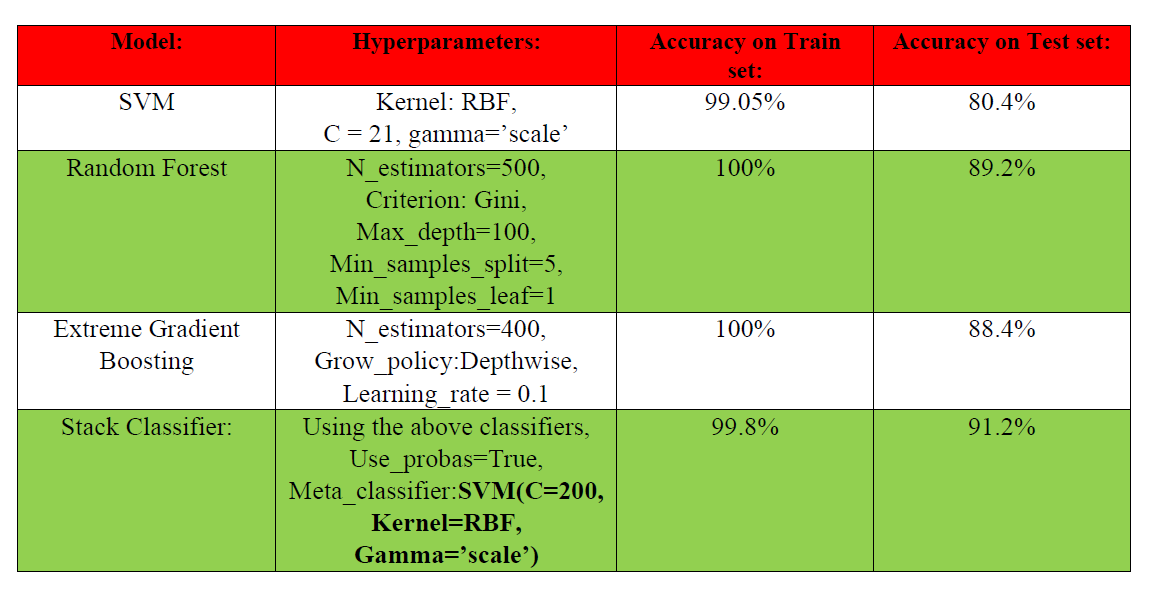

###### Discussion:

Comparing the results with the model without explicit feature extraction, using spectogram feature vector increased the accuracy of model from 43.4% to 91.2%, meaning that we had a 47.8% better performance on the test set. This implies the importance of feature extraction and specifically, the importance of spectogram of audio signals in the classification tasks.

In the next part, we imporove our results by extracting better features:

<center> -----------------------------------------------------------------------------------------------------

## Bonus Part: Extracting more and better features to improve the model

We use **pyAudioAnalysis** to extract more features from the dataset; This library uses creates some powerful and practical features in audio analysis in each window(which the best possible value for window sizes was found by trial-and-error); Some of its most important features are as below:

**Zero-Crossing Rate**:The rate of sign changes of the signal during the duration of a particular frame.

**Energy**:The sum of squares of the signal values, normalized by the respective frame length.

**Entropy of Energy**:The entropy of sub-frames normalized energies. It can be interpreted as a measure of abrupt changes.

**Spectral Centroid**:The center of gravity of the spectrum.

**MFCCs (9-21)**:Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.

etc. The full list of the features can be found in the below links of the **pyAudio** documentation:
<br>https://dolby.io/blog/creating-audio-features-with-pyaudio-analysis/
<br>https://github.com/tyiannak/pyAudioAnalysis

Also, I added the signal spectogram in each frame as well to increase the number of important features:

In [407]:
from pyAudioAnalysis import ShortTermFeatures
from pyAudioAnalysis import MidTermFeatures

In [639]:
X_train_pyAudio = []
for x in X_train:
    _,_, Sx = signal.spectrogram(x, 8000, window=windows.hann(120))
    mid_feat = MidTermFeatures.mid_feature_extraction(x, 8000, 2000, 2000, 500, 400)
    X_train_pyAudio.append(np.hstack((np.ravel(Sx), np.ravel(mid_feat[0]), np.ravel(mid_feat[1]))))
X_train_pyAudio = np.array(X_train_pyAudio)

In [640]:
X_test_pyAudio = []
for x in X_test:
    _,_, Sx = signal.spectrogram(x, 8000, window=windows.hann(120))
    mid_feat = MidTermFeatures.mid_feature_extraction(x, 8000, 2000, 2000, 500, 400)
    X_test_pyAudio.append(np.hstack((np.ravel(Sx), np.ravel(mid_feat[0]), np.ravel(mid_feat[1]))))
X_test_pyAudio = np.array(X_test_pyAudio)

In [641]:
rf_model_pyA = Random_Forest(n_estimators=500,
                             criterion='entropy',
                             max_depth=100,
                             min_samples_split=5,
                             min_samples_leaf=1,
                             #max_samples=2000,
                             random_state=0)
                             
rf_model_pyA.fit(X_train_pyAudio, Y_train)

print('Accuracy of model on train set:', rf_model_pyA.score(X_train_pyAudio, Y_train))
print('Accuracy of model on test set:', rf_model_pyA.score(X_test_pyAudio, Y_test))

Accuracy of model on train set: 1.0
Accuracy of model on test set: 0.916


In [560]:
svmLin_model_pyA = SVC(C=0.1, kernel='linear', probability=True, random_state=0)
svmLin_model_pyA.fit(X_train_pyAudio, Y_train)

print('Accuracy of model on train set:', svmLin_model_pyA.score(X_train_pyAudio, Y_train))
print('Accuracy of model on test set:', svmLin_model_pyA.score(X_test_pyAudio, Y_test))

Accuracy of model on train set: 0.9885
Accuracy of model on test set: 0.93


In [642]:
svmRBF_model_pyA = SVC(C=450, kernel='rbf', gamma='scale', probability=True, random_state=0)
svmRBF_model_pyA.fit(X_train_pyAudio, Y_train)

print('Accuracy of model on train set:', svmRBF_model_pyA.score(X_train_pyAudio, Y_train))
print('Accuracy of model on test set:', svmRBF_model_pyA.score(X_test_pyAudio, Y_test))

Accuracy of model on train set: 0.986
Accuracy of model on test set: 0.924


In [643]:
xgb_model_pyA = XGB(n_estimators=200, grow_policy='depthwise',
                   use_label_encoder=None, learning_rate=0.1,
                   random_state=0)
xgb_model_pyA.fit(X_train_pyAudio, Y_train)

print('Accuracy of model on train set:', xgb_model_pyA.score(X_train_pyAudio, Y_train))
print('Accuracy of model on test set:', xgb_model_pyA.score(X_test_pyAudio, Y_test))

[03:08:48] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of model on train set: 1.0
Accuracy of model on test set: 0.934


As we can see, all the individual classifiers had a better performance than the previous part models; Also, we can boost our model using idea of stack classifiers and using SVM classifier with RBF kernel as the meta classifier again.

In [605]:
stackClassifier = StackingCVClassifier(classifiers = [svmLin_model_pyA, svmRBF_model_pyA, rf_model_pyA, xgb_model_pyA],
                            shuffle = True,
                            use_probas = True,
                            cv = 4,
                            verbose=1,
                            meta_classifier = SVC(kernel='rbf', C=10, gamma=1e-4, random_state=0))

stackClassifier.fit(X_train_pyAudio, Y_train)

Fitting 4 classifiers...
Fitting classifier1: svc (1/4)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   21.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: svc (2/4)


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   44.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: randomforestclassifier (3/4)


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: xgbclassifier (4/4)
[00:20:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:46] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:27:27] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:31:08] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set ev

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 14.5min finished


[00:35:54] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


StackingCVClassifier(classifiers=[SVC(C=0.1, kernel='linear', probability=True,
                                      random_state=0),
                                  SVC(C=450, probability=True, random_state=0),
                                  RandomForestClassifier(criterion='entropy',
                                                         max_depth=100,
                                                         min_samples_split=5,
                                                         n_estimators=500,
                                                         random_state=0),
                                  XGBClassifier(base_score=0.5,
                                                booster='gbtree',
                                                colsample_bylevel=1,
                                                colsample_bynode=1,
                                                colsample_bytree=1,...
                                                min_child_weight=1, missing=nan,
                                                monotone_constraints='()',
                                                n_estimators=200, n_jobs=8,
                                                num_parallel_tree=1,
                                                objective='multi:softprob',
                                                predictor='auto',
                                                random_state=77, reg_alpha=0,
                                                reg_lambda=1,
                                                scale_pos_weight=None,
                                                subsample=1,
                                                tree_method='exact',
                                                use_label_encoder=None,
                                                validate_parameters=1, ...)],
                     cv=4,
                     meta_classifier=SVC(C=10, gamma=0.0001, random_state=0),
                     use_probas=True, verbose=1)

In [606]:
Yhat_test = stackClassifier.predict(X_test_pyAudio)
print('Accuracy of model on train set:', stackClassifier.score(X_train_pyAudio, Y_train))
print('Accuracy of model on test set:', stackClassifier.score(X_test_pyAudio, Y_test))

Accuracy of model on train set: 0.999
Accuracy of model on test set: 0.954


In [607]:
cm = confusion_matrix(Y_test, Yhat_test)
conf_all = pd.DataFrame(cm)
conf_all

,0,1,2,3,4,5,6,7,8,9
0,47,0,0,1,0,0,1,0,0,1
1,0,46,0,0,2,2,0,0,0,0
2,1,0,48,1,0,0,0,0,0,0
3,0,0,5,45,0,0,0,0,0,0
4,0,0,0,0,50,0,0,0,0,0
5,0,0,0,0,0,50,0,0,0,0
6,0,0,0,0,0,0,46,2,2,0
7,0,0,1,0,0,0,0,48,1,0
8,0,0,0,1,0,0,1,0,48,0
9,0,0,0,0,0,0,0,1,0,49


As we can see, this model had the best performance among all the models on the test data and we could reach a 95.4% accuracy on test set, which simply means only 23 test samples are misclassified and 4.2% boost relative to previous model. Classes 4 and 5 are perfectly classified; however, class 3 had a slightly lower classifiaction accuracy in comparison with others.

In [796]:
with open('AlirezaGargoori_98102176/Phase_2b/Model_Phase2b.pkl', 'wb') as files:
    pickle.dump(stackClassifier, files)

In [801]:
def Predict_Phase2b(path_data, path_module):
    #Preprocess the data
    X_train, Y_train, X_test, Y_test = load_preprocess_data(path_data)
    
    X_train_pyAudio = []
    for x in X_train:
        _,_, Sx = signal.spectrogram(x, 8000, window=windows.hann(120))
        mid_feat = MidTermFeatures.mid_feature_extraction(x, 8000, 2000, 2000, 500, 400)
        X_train_pyAudio.append(np.hstack((np.ravel(Sx), np.ravel(mid_feat[0]), np.ravel(mid_feat[1]))))

    X_test_pyAudio = []
    for x in X_test:
        _,_, Sx = signal.spectrogram(x, 8000, window=windows.hann(120))
        mid_feat = MidTermFeatures.mid_feature_extraction(x, 8000, 2000, 2000, 500, 400)
        X_test_pyAudio.append(np.hstack((np.ravel(Sx), np.ravel(mid_feat[0]), np.ravel(mid_feat[1]))))
    X_test_pyAudio = np.array(X_test_pyAudio)
    
    with open(path_module + 'Model_Phase2b.pkl', 'rb') as f:
        phase2b_model = pickle.load(f)
    
    print('Accuracy of the best model on train set:', phase2b_model.score(X_train_pyAudio, Y_train))
    print('Accuracy of the best model on test set:', phase2b_model.score(X_test_pyAudio, Y_test))
    
    np.save(path_module+'phase2b_predicted.npy', phase2b_model.predict(X_test_pyAudio))

In [802]:
Predict_Phase2b('AlirezaGargoori_98102176/Dataset/', 'AlirezaGargoori_98102176/Phase_2b/')

Accuracy of the best model on train set: 0.999
Accuracy of the best model on test set: 0.954


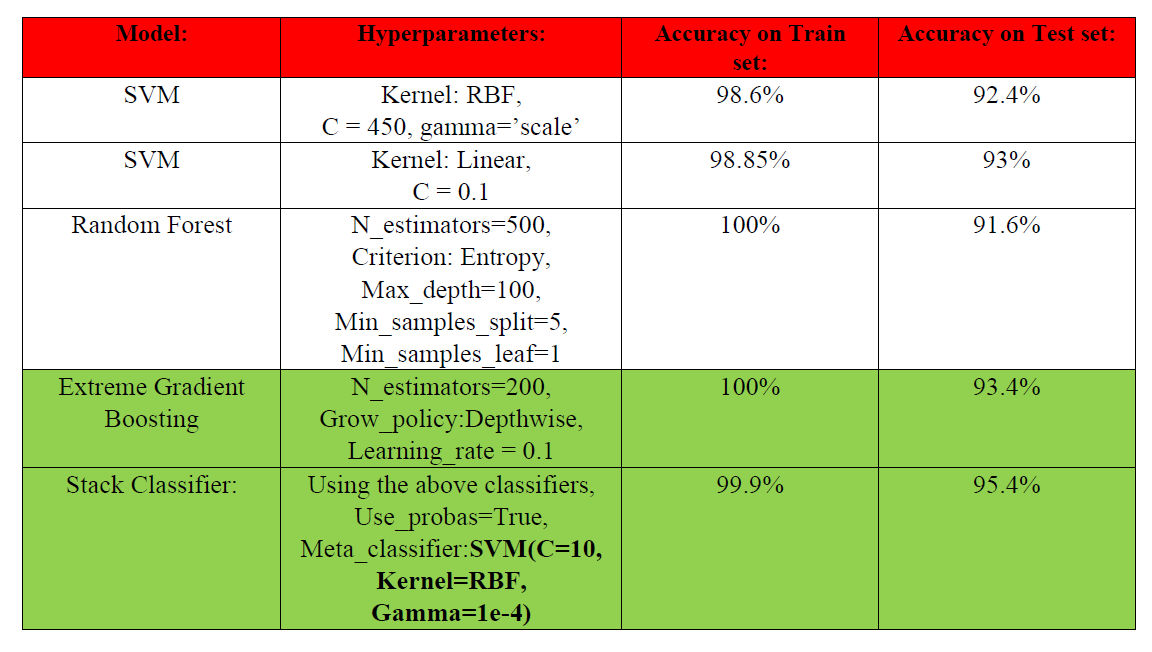

# Phase 3: Unsupervised learning for preprocessing

We randomly select 5 samples from each class and train the model using Random Forest Classifier:

In [808]:
import random

random.seed(1)
samples_ind = []
for i in range(0, 2000, 200):
    ind = random.sample(range(i,i+200), 5)
    samples_ind.append(ind)
samples_ind = np.ravel(np.array(samples_ind))


X_sample = X_train_tf[samples_ind, :]
Y_sample = Y_train[samples_ind]

clf_a = Random_Forest(n_estimators=400,
                      criterion='entropy',
                      max_depth=100,
                      min_samples_split=5,
                      min_samples_leaf=1,
                      random_state=0)

clf_a.fit(X_sample, Y_sample)

print('Accuracy of model on full train set:', clf_a.score(X_train_tf, Y_train))
print('Accuracy of model on full test set:', clf_a.score(X_test_tf, Y_test))

Accuracy of model on full train set: 0.5785
Accuracy of model on full test set: 0.59


Now, we cluster our data to 50 clusters and find the representative of each clusters by finding the closest sample to each cluster centroid. Then we train the previous model using the representative samples of each cluster:

In [815]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

Kmeans_model = KMeans(n_clusters=50, random_state=1234).fit(X_train_tf)
#Find the centroids and closest point to each cluster centroid to use as the representation of that cluster
cluster_centers = Kmeans_model.cluster_centers_
rep_ind, _ = pairwise_distances_argmin_min(cluster_centers, X_train_tf)
X_train_cluster = X_train_tf[rep_ind,:]
Y_train_cluster = Y_train[rep_ind]


#Train the model and find the accuracies on full train and test sets
clf_b = Random_Forest(n_estimators=400,
                      criterion='entropy',
                      max_depth=100,
                      min_samples_split=5,
                      min_samples_leaf=1,
                      random_state=0)
clf_b.fit(X_train_cluster, Y_train_cluster)

print('Accuracy of model on full train set:', clf_b.score(X_train_tf, Y_train))
print('Accuracy of model on full test set:', clf_b.score(X_test_tf, Y_test))

Accuracy of model on full train set: 0.524
Accuracy of model on full test set: 0.498


Now, instead of labeling each sample from the class of their cluster representative, we predict their lables using a random forest classifer:

In [845]:
label_predictor_model = Random_Forest(n_estimators=200,
                                      criterion='gini',
                                      max_depth=100,
                                      min_samples_split=2,
                                      min_samples_leaf=1,
                                      random_state=0)
label_predictor_model.fit(X_train_cluster, Y_train_cluster)

train_predicted_labels = label_predictor_model.predict(X_train_tf)

Now, using the semi-supervised labeling of all the train data, we train a new model and check the accuracies:

In [846]:
clf_c = Random_Forest(n_estimators=500,
                      criterion='entropy',
                      max_depth=150,
                      min_samples_split=5,
                      min_samples_leaf=1,
                      random_state=0)

clf_c.fit(X_train_tf, train_predicted_labels)

print('Accuracy of model on full train set:', clf_c.score(X_train_tf, Y_train))
print('Accuracy of model on full test set:', clf_c.score(X_test_tf, Y_test))

Accuracy of model on full train set: 0.5305
Accuracy of model on full test set: 0.512


As we can see, by tuning the hyperparamters, the model could predict more than half of the labels correctly; yet, due to the lack of number of clusters, this is far from what we really need to predict the true labels with a reliable algorithm; In other words, by increasing the number of clusters, we can have a better accuracy on the test set in expense of more true labels by a human agent.

In comparison with previous models in this phase, this model is a bit more rebust, meaning that by running this method repeatedly and averaging the results, the accuracy has a smaller confidence intervel. But the first method, making a classifier using the 50 random samples, the model heavily depends on the sampling and the accuracy can change a lot. Also, the second model where we predicted the classes using the cluster centroids, suffers from the lack of training data; meaning that we could have only 50 samples to train our model which is not a good option (More data points results in better and more reliable models and reduces the variance of model.) As we can observe, the third model had a better performance as well, but to make the results even better, as said in the above paragraph, we need more true labels and more clusters which has its own expense as well.

## *The End!*